In [1]:
library(DESeq2)
library(TCGAbiolinks)
library(biomaRt)
library(clusterProfiler)
library(org.Hs.eg.db)
library(enrichplot)
library(ggplot2)
library(GEOquery)
library(sva)
library(limma)
library(miRBaseConverter)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: generics


Attaching package: ‘generics’


The following objects are masked from ‘package:base’:

    as.difftime, as.factor, as.ordered, intersect, is.element, setdiff,
    setequal, union



Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, saveRDS, table, tapply, unique,
    unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The follo

In [2]:
library(dplyr)
library(tidyr)
select <- dplyr::select


Attaching package: ‘dplyr’


The following object is masked from ‘package:nlme’:

    collapse


The following object is masked from ‘package:AnnotationDbi’:

    select


The following object is masked from ‘package:biomaRt’:

    select


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:matrixStats’:

    count


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:Seqinfo’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, setequal, union


The following object is masked from ‘package:generics’:

    explain


The following objects are masked 

In [3]:
mart113 <- useEnsembl(biomart="genes", dataset="hsapiens_gene_ensembl", host="https://oct2024.archive.ensembl.org")

In [4]:
# First do the Sample IDs thing for long names
manifest <- read.delim("tcga_data_all/gdc_manifest.2025-12-06.200202.txt", header = TRUE)
uuids <- manifest$id

In [5]:
rna_gdcquery <- GDCquery(
  project = c("TCGA-COAD", "TCGA-READ"),
  data.category = "Transcriptome Profiling",
  data.type = "Gene Expression Quantification",
  access = "open",
)

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-COAD

ooo Project: TCGA-READ

--------------------

oo Filtering results

--------------------

ooo By access

ooo By data.type

----------------

oo Checking data

----------------

ooo Checking if there are duplicated cases

ooo Checking if there are results for the query

-------------------

o Preparing output

-------------------



In [6]:
results <- rna_gdcquery$results[[1]]
barcode_table <- results %>%
  select(file_name, cases)

In [7]:
mirna_gdcquery <- GDCquery(
  project = c("TCGA-COAD", "TCGA-READ"),
  data.category = "Transcriptome Profiling",
  data.type = "miRNA Expression Quantification",
  access = "open",
)

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-COAD

ooo Project: TCGA-READ

--------------------

oo Filtering results

--------------------

ooo By access

ooo By data.type

----------------

oo Checking data

----------------

ooo Checking if there are duplicated cases

ooo Checking if there are results for the query

-------------------

o Preparing output

-------------------



In [8]:
mirnaquery_results <- mirna_gdcquery$results[[1]]
mirna_barcode_table <- mirnaquery_results %>%
  select(file_name, cases)

In [9]:
# Load mRNA and miRNA data
rna_counts <- read.table("tcga_data_all/count_matrices/RNA_merged_counts.tsv", header=TRUE, sep="\t", row.names=1, check.names = FALSE)
mirna_counts <- read.table("tcga_data_all/count_matrices/miRNA_merged_counts.tsv", header=TRUE, sep="\t", row.names=1, check.names = FALSE)

In [10]:
new_rna_colnames <- barcode_table$cases[match(colnames(rna_counts), barcode_table$file_name)]
colnames(rna_counts) <- new_rna_colnames

In [11]:
new_mirna_colnames <- mirna_barcode_table$cases[match(colnames(mirna_counts), mirna_barcode_table$file_name)]
colnames(mirna_counts) <- new_mirna_colnames

In [12]:
# Load the metadata for each one
all_metadata <- read.table("tcga_data_all/gdc_sample_sheet.2025-12-06.tsv", header=TRUE, sep="\t")
rna_metadata <- all_metadata[all_metadata$Data.Type == "Gene Expression Quantification", ]
mirna_metadata <- all_metadata[all_metadata$Data.Type == "miRNA Expression Quantification", ]

# add to the rna metadata the matching cases from the barcode table
rna_metadata$cases <- barcode_table$cases[match(rna_metadata$File.Name, barcode_table$file_name)]
rownames(rna_metadata) <- rna_metadata$cases
rna_metadata <- rna_metadata[colnames(rna_counts), ]

mirna_metadata$cases <- mirna_barcode_table$cases[match(mirna_metadata$File.Name, mirna_barcode_table$file_name)]
rownames(mirna_metadata) <- mirna_metadata$cases
mirna_metadata <- mirna_metadata[colnames(mirna_counts), ]

In [13]:
ensg_ids <- rownames(rna_counts)
ensg_ids <- sub("\\..*$", "", ensg_ids)
annot <- getBM(
  attributes = c("ensembl_gene_id", "external_gene_name"),
  filters = "ensembl_gene_id",
  values = ensg_ids,
  mart = mart113
)
#head(annot, 1)

In [14]:
# move on from chaning ensg id to gene name, now do the differential expression
rna_counts <- as.matrix(rna_counts)
dds <- DESeqDataSetFromMatrix(countData = rna_counts,
                              colData = rna_metadata,
                              design = ~ Tissue.Type)
dds <- DESeq(dds)
res <- results(dds, contrast=c("Tissue.Type", "Tumor", "Normal"))

res = res[order(res$padj), ]
res <- res[!is.na(res$padj), ]

res_ordered <- res[order(res$padj), ]
df = res_ordered
df$Category <- "Not significant" # Criteria can be changed
df[which(df$log2FoldChange > 2 & df$padj <= 0.05),]$Category <- "Up-regulated"
df[which(df$log2FoldChange <= -2 & df$padj <= 0.05),]$Category <- "Down-regulated"

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1685 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [15]:
log2fc_thresh <- 2
padj_thresh   <- 0.05
df$negLog10Padj <- -log10(df$padj)

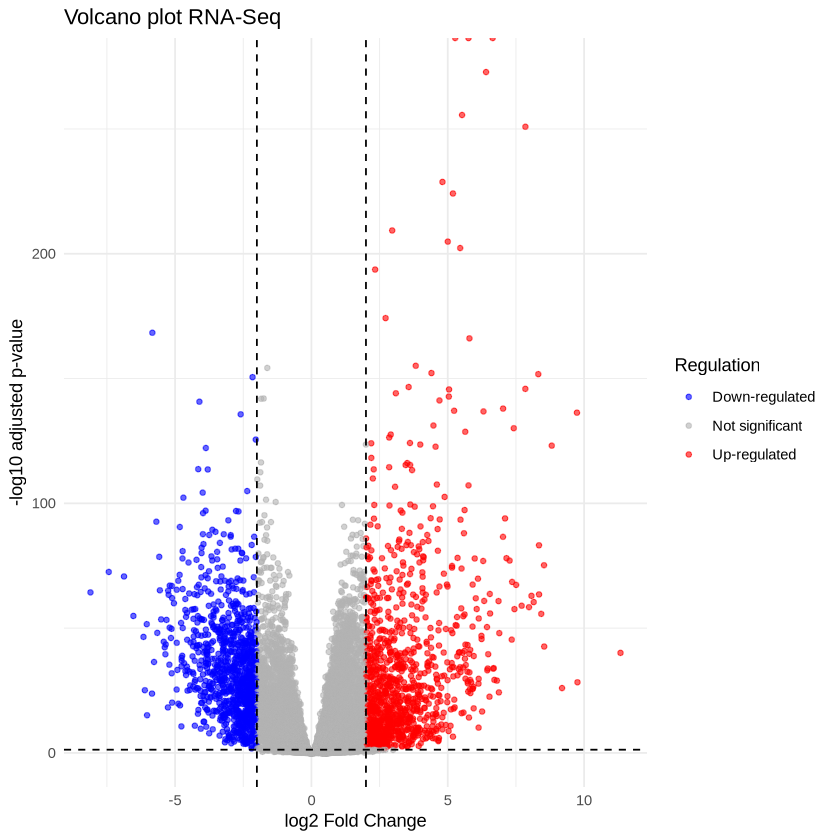

In [16]:
p_volcano <- ggplot(df, aes(x = log2FoldChange, y = negLog10Padj, color = Category)) +
  geom_point(alpha = 0.6, size = 1.2) +
  scale_color_manual(values = c("Down-regulated" = "blue", "Not significant" = "grey70", "Up-regulated" = "red")) +
  geom_vline(xintercept = c(-log2fc_thresh, log2fc_thresh), linetype = "dashed") +
  geom_hline(yintercept = -log10(padj_thresh), linetype = "dashed") +
  labs(
    x = "log2 Fold Change",
    y = "-log10 adjusted p-value",
    color = "Regulation",
    title = "Volcano plot RNA-Seq"
  ) +
  theme_minimal()

p_volcano

In [75]:
df_genes <- rownames(df)
# annotate with gene names
df_genes <- sub("\\..*$", "", df_genes)
annotated_genes <- getBM(
  attributes = c("ensembl_gene_id", "external_gene_name"),
  filters = "ensembl_gene_id",
  values = df_genes,
  mart = mart113
)
# match gene names with the gene ids in the df, put the gene names in a new column
df$GeneName <- annotated_genes$external_gene_name[match(sub("\\..*$", "", rownames(df)), annotated_genes$ensembl_gene_id)]

In [76]:
# write differential expression as file for further analysis
write.table(df, file="deseq2_differential_expression_RNAseq.tsv", sep="\t", quote=FALSE, row.names=FALSE)

In [17]:
table(df$Category)


 Down-regulated Not significant    Up-regulated 
           1035           17336            1125 

In [18]:
df_sig <- df[df$Category != "Not significant", ]
df_sig$ENSG <- rownames(df_sig)
df_sig$ENSG <- sub("\\..*$", "", df_sig$ENSG)
df_sig$ENTREZ <- mapIds(org.Hs.eg.db,
                           keys = df_sig$ENSG,
                           column = "ENTREZID",
                           keytype = "ENSEMBL",
                           multiVals = "first")
df_sig <- df_sig[!is.na(df_sig$ENTREZ), ]
gene_list <- df_sig$ENTREZ

'select()' returned 1:many mapping between keys and columns



In [19]:
ego <- enrichGO(gene         = gene_list,
                    OrgDb        = org.Hs.eg.db,
                    keyType      = 'ENTREZID',
                    ont          = "BP",
                    pAdjustMethod = "BH",
                    pvalueCutoff  = 0.01,
                    qvalueCutoff  = 0.05,
                    readable      = TRUE)

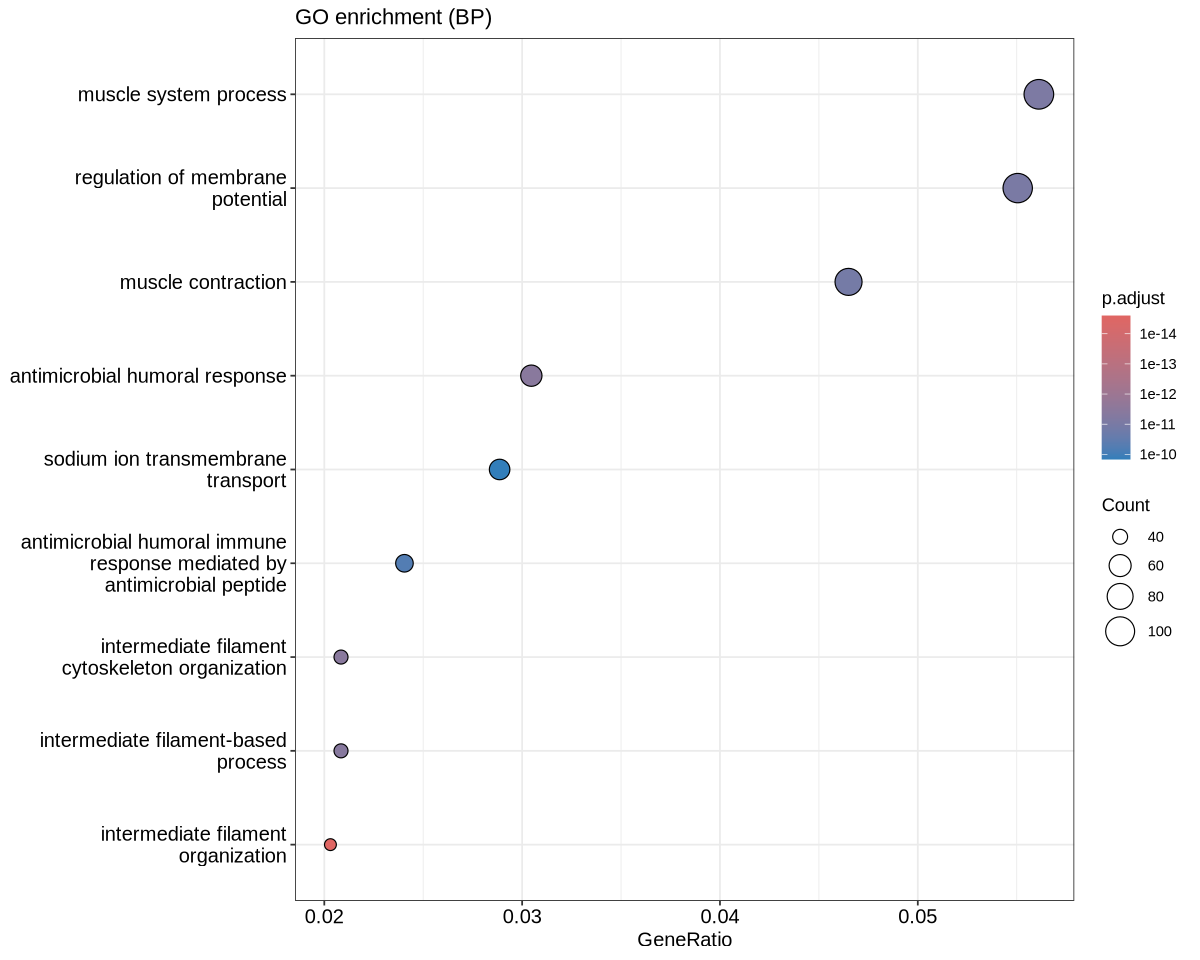

In [20]:
options(repr.plot.width = 10, repr.plot.height = 8)
dotplot(ego, showCategory = 9) + 
  ggtitle("GO enrichment (BP)")

In [21]:
# differential expression analysis for miRNA data can be done similarly
mirna_counts <- as.matrix(mirna_counts)
dds <- DESeqDataSetFromMatrix(countData = mirna_counts,
                              colData = mirna_metadata,
                              design = ~ Tissue.Type)
dds <- DESeq(dds)
res <- results(dds, contrast=c("Tissue.Type", "Tumor", "Normal"))

res = res[order(res$padj), ]
res <- res[!is.na(res$padj), ]

res_ordered <- res[order(res$padj), ]
df_mirna = res_ordered
df_mirna$Category <- "Not significant" # Criteria can be changed
df_mirna[which(df_mirna$log2FoldChange > 2 & df_mirna$padj <= 0.05),]$Category <- "Up-regulated"
df_mirna[which(df_mirna$log2FoldChange <= -2 & df_mirna$padj <= 0.05),]$Category <- "Down-regulated"

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 42 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



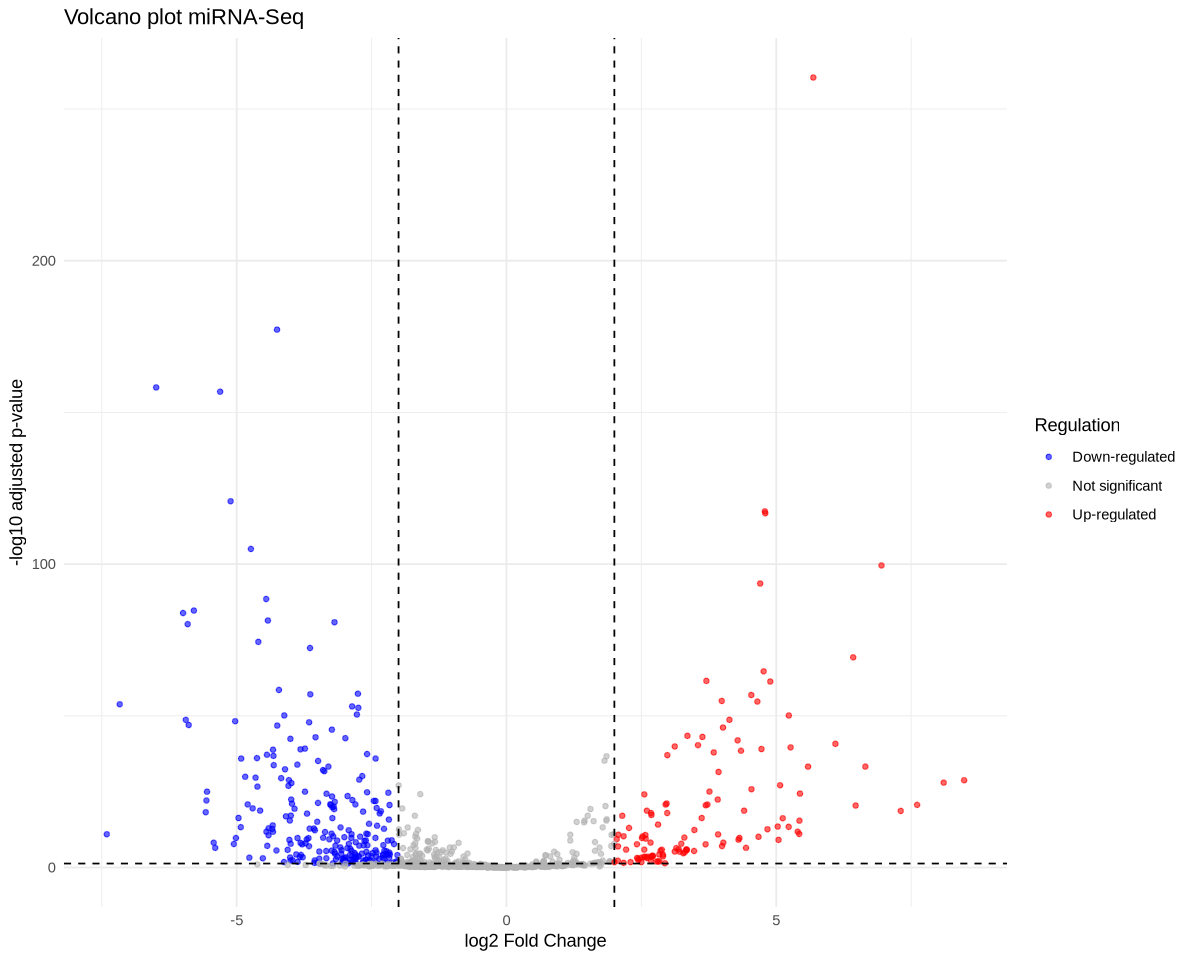

In [22]:
df_mirna$negLog10Padj <- -log10(df_mirna$padj)
p_volcano <- ggplot(df_mirna, aes(x = log2FoldChange, y = negLog10Padj, color = Category)) +
  geom_point(alpha = 0.6, size = 1.2) +
  scale_color_manual(values = c("Down-regulated" = "blue", "Not significant" = "grey70", "Up-regulated" = "red")) +
  geom_vline(xintercept = c(-log2fc_thresh, log2fc_thresh), linetype = "dashed") +
  geom_hline(yintercept = -log10(padj_thresh), linetype = "dashed") +
  labs(
    x = "log2 Fold Change",
    y = "-log10 adjusted p-value",
    color = "Regulation",
    title = "Volcano plot miRNA-Seq"
  ) +
  theme_minimal()

p_volcano

In [23]:
table(df$Category)


 Down-regulated Not significant    Up-regulated 
           1035           17336            1125 

In [24]:
table(df_mirna$Category)


 Down-regulated Not significant    Up-regulated 
            244             639             121 

In [66]:
# write the results to a file
write.table(df_mirna, file="deseq2_differential_expression_miRNAseq.tsv", sep="\t", quote=FALSE, row.names=TRUE)

In [25]:
sig_genes <- rownames(df[df$Category != "Not significant", ])
sig_mirnas <- rownames(df_mirna[df_mirna$Category != "Not significant", ])

In [26]:
# sig_mirnas # parten con hsa-mir-id

In [27]:
# sig_genes # tienen los ensg_ids

In [28]:
# Process the GEO datasets
gse_ids <- c("GSE121895", "GSE126094", "GSE138589", "GSE142837")
gse_list <- lapply(gse_ids, function(gse_id) {
  getGEO(gse_id, GSEMatrix = TRUE)[[1]]
})
names(gse_list) <- gse_ids

Found 1 file(s)

GSE121895_series_matrix.txt.gz

Found 1 file(s)

GSE126094_series_matrix.txt.gz

Found 1 file(s)

GSE138589_series_matrix.txt.gz

Using locally cached version of GPL19978 found here:
/tmp/RtmpN4veKF/GPL19978.soft.gz 

Found 1 file(s)

GSE142837_series_matrix.txt.gz

Using locally cached version of GPL19978 found here:
/tmp/RtmpN4veKF/GPL19978.soft.gz 



In [29]:
expr_list <- lapply(gse_list, exprs)   # list of matrices
pheno_list <- lapply(gse_list, pData)  # list of metadata
gpl_list <- lapply(gse_list, fData)  # list of platform annotation
expr1 <- expr_list[[1]]
expr2 <- expr_list[[2]]
expr3 <- expr_list[[3]]
expr4 <- expr_list[[4]]

gpl1 <- gpl_list[[1]]
gpl2 <- gpl_list[[2]]
gpl3 <- gpl_list[[3]]
gpl4 <- gpl_list[[4]]

In [30]:
colnames(gpl1)

[1] "ID"       "circRNA"  "TYPE"     "BUILD"    "SEQUENCE"

In [31]:
# Replace platform-specific IDs with circRNAs
annot1 <- gpl1[, c("ID", "circRNA")]
annot2 <- gpl2[, c("ID", "circRNA")]
annot3 <- gpl3[, c("ID", "circRNA")]
annot4 <- gpl4[, c("ID", "circRNA")]

# match each epxression matrix rownames with its corresponding circRNA
expr1_ids <- annot1$circRNA[match(rownames(expr1), annot1$ID)]
rownames(expr1) <- expr1_ids
expr2_ids <- annot2$circRNA[match(rownames(expr2), annot2$ID)]
rownames(expr2) <- expr2_ids
expr3_ids <- annot3$circRNA[match(rownames(expr3), annot3$ID)]
rownames(expr3) <- expr3_ids
expr4_ids <- annot4$circRNA[match(rownames(expr4), annot4$ID)]
rownames(expr4) <- expr4_ids

In [32]:
# get common rows (genes) of expr1, 2, 3, 4
common_genes <- Reduce(intersect, list(rownames(expr1), rownames(expr2), rownames(expr3), rownames(expr4)))
# Make the merged expression matrix with only common genes
expr1_common <- expr1[common_genes, ]
expr2_common <- expr2[common_genes, ]
expr3_common <- expr3[common_genes, ]
expr4_common <- expr4[common_genes, ]
expr_merged <- cbind(expr1_common, expr2_common, expr3_common, expr4_common)

In [33]:
pheno1 <- pheno_list[[1]]
pheno2 <- pheno_list[[2]]
pheno3 <- pheno_list[[3]]
pheno4 <- pheno_list[[4]]

pheno1$geo_id <- gse_ids[1]
pheno2$geo_id <- gse_ids[2]
pheno3$geo_id <- gse_ids[3]
pheno4$geo_id <- gse_ids[4] 

In [34]:
# Make a column in pheno 1 that is "disease status" based on the existing column
pheno1$condition <- ifelse(grepl("tissues: carcinoma tissues", pheno1$characteristics_ch1), "Tumor", "Normal")
pheno2$condition <- ifelse(grepl("tissue: colorectal cancer tissue", pheno2$`characteristics_ch1.1`), "Tumor", "Normal")
pheno3$condition <- ifelse(grepl("colorectal cancerr", pheno3$source_name_ch1), "Tumor", "Normal")
pheno4$condition <- ifelse(grepl("colorectal cancer tissue", pheno4$`tissue:ch1`), "Tumor", "Normal")

In [35]:
# keep only geo_accession, geo_id and condition for each pheno
pheno1 <- pheno1[, c("geo_accession", "geo_id", "condition")]
pheno2 <- pheno2[, c("geo_accession", "geo_id", "condition")]
pheno3 <- pheno3[, c("geo_accession", "geo_id", "condition")]
pheno4 <- pheno4[, c("geo_accession", "geo_id", "condition")]

# combine all pheno dataframes
pheno_merged <- rbind(pheno1, pheno2, pheno3, pheno4)

In [36]:
batch <- factor(pheno_merged$geo_id)
condition <- factor(pheno_merged$condition, levels = c("Normal", "Tumor"))
mod <- model.matrix(~condition)

In [37]:
expr_corrected <- ComBat(
    dat = expr_merged,
    batch = batch,
    mod = mod,
    par.prior = TRUE,
    prior.plots = FALSE
)

Found4batches

Adjusting for1covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




In [38]:
expr_combat <- expr_corrected

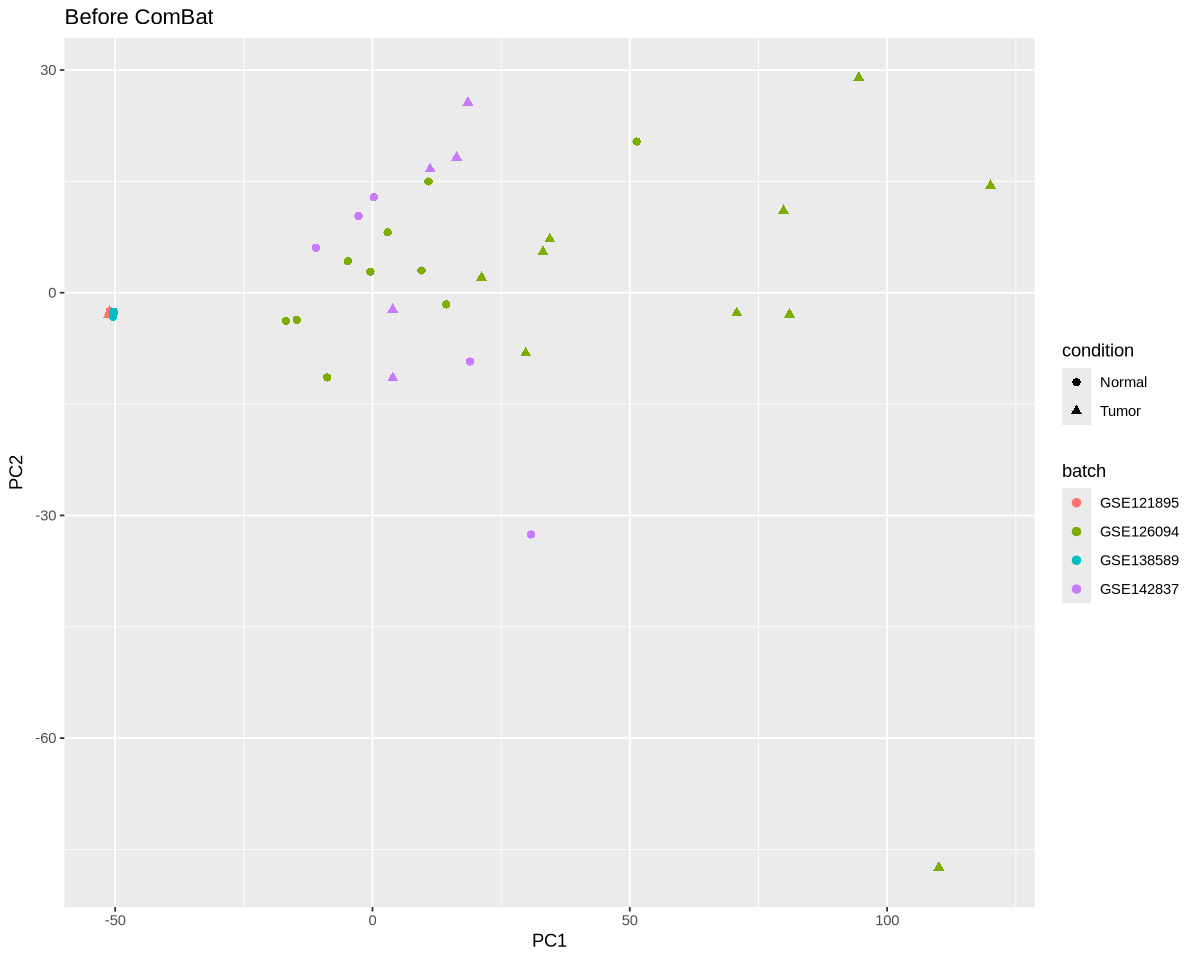

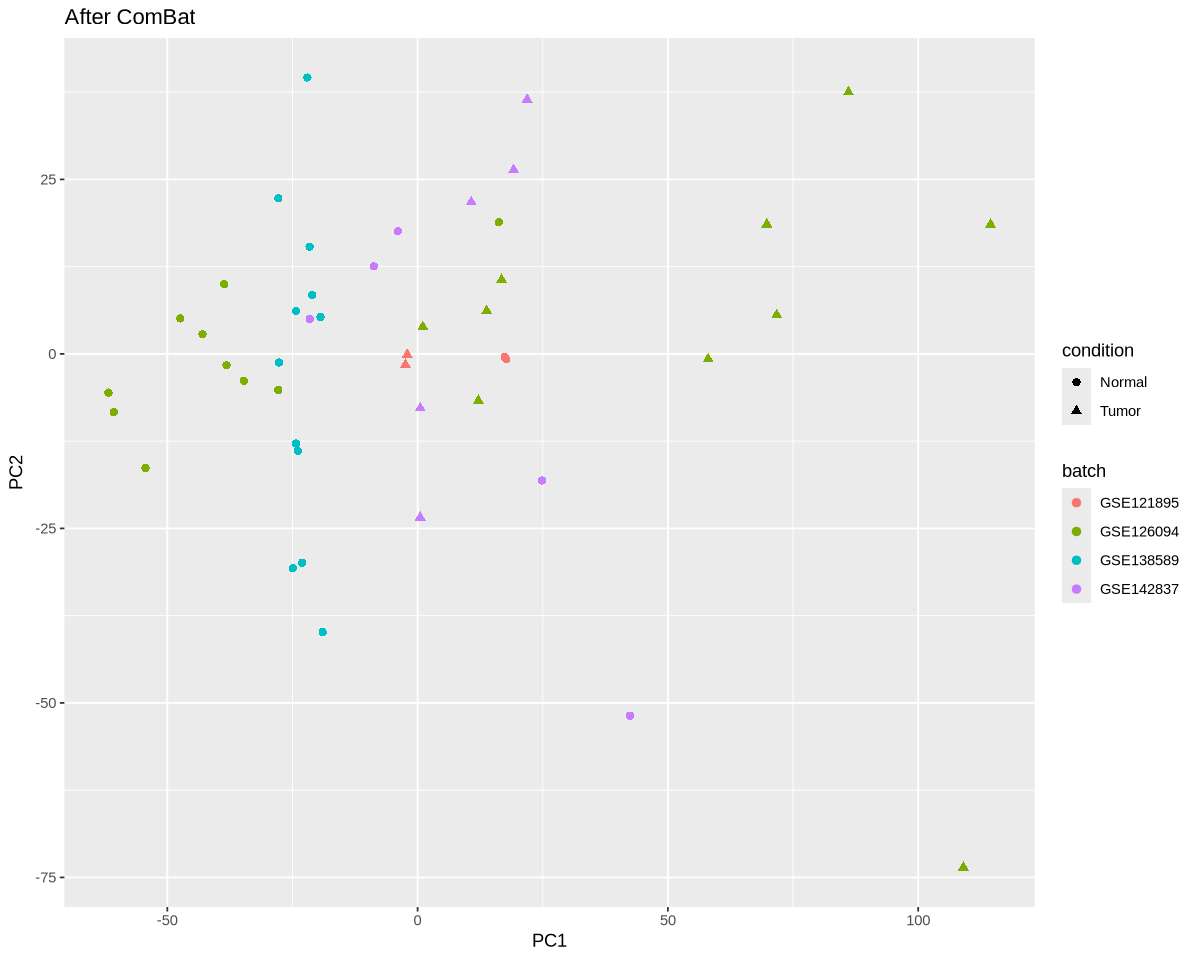

In [39]:
batch     <- factor(pheno_merged$geo_id)
condition <- factor(pheno_merged$condition)

# BEFORE ComBat
pca_before <- prcomp(t(expr_merged), scale. = TRUE)
df_before <- data.frame(PC1=pca_before$x[,1],
                        PC2=pca_before$x[,2],
                        batch=batch,
                        condition=condition)

ggplot(df_before, aes(PC1, PC2, color=batch, shape=condition)) +
  geom_point(size=2) +
  ggtitle("Before ComBat")

# AFTER ComBat
pca_after <- prcomp(t(expr_combat), scale. = TRUE)
df_after <- data.frame(PC1=pca_after$x[,1],
                       PC2=pca_after$x[,2],
                       batch=batch,
                       condition=condition)

ggplot(df_after, aes(PC1, PC2, color=batch, shape=condition)) +
  geom_point(size=2) +
  ggtitle("After ComBat")

In [40]:
# Now we can do differential expression analysis on expr_corrected, using limma
condition <- factor(pheno_merged$condition, levels = c("Normal", "Tumor"))
design <- model.matrix(~condition)
colnames(design) <- levels(condition)

contrast.matrix <- makeContrasts(Tumor - Normal, levels=design)
fit <- lmFit(expr_corrected, design)
fit2 <- contrasts.fit(fit, contrast.matrix)
fit2 <- eBayes(fit2)

res <- topTable(fit2, coef=1, number=Inf, sort.by="P")
# remove Nas from res
res <- res[!is.na(res$adj.P.Val), ]

# add Category column
res$Category <- "Not significant"
res[which(res$logFC > 1 & res$adj.P.Val <= 0.05),]$Category <- "Up-regulated"
res[which(res$logFC <= -1 & res$adj.P.Val <= 0.05),]$Category <- "Down-regulated"


In [41]:
table(res$Category)


 Down-regulated Not significant    Up-regulated 
            617            2461              80 

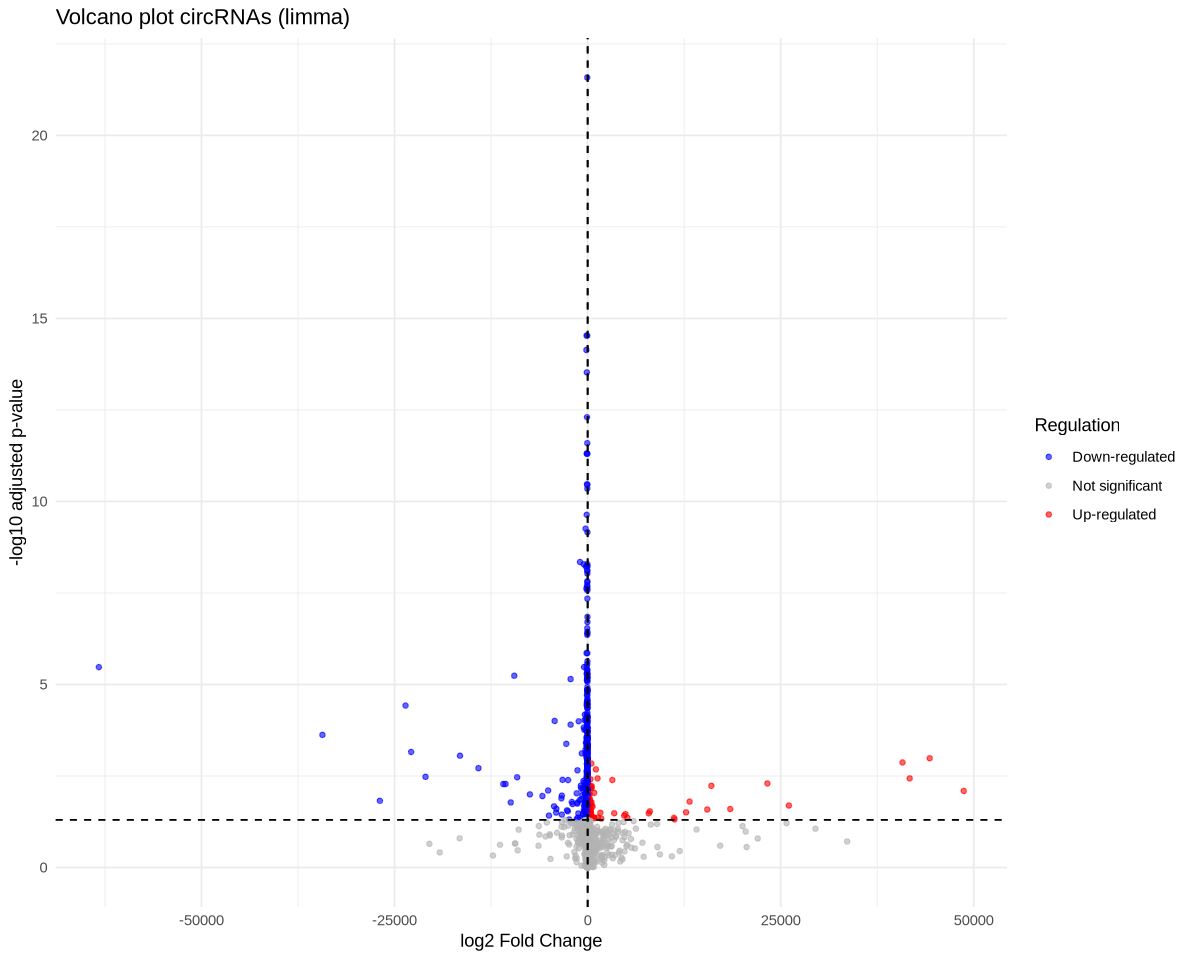

In [42]:
# Make volcano plot of the limma results
log2fc_thresh <- 1
padj_thresh   <- 0.05
res$negLog10Padj <- -log10(res$adj.P.Val)
p_volcano <- ggplot(res, aes(x = logFC, y = negLog10Padj, color = Category)) +
  geom_point(alpha = 0.6, size = 1.2) +
  scale_color_manual(values = c("Down-regulated" = "blue", "Not significant" = "grey70", "Up-regulated" = "red")) +
  geom_vline(xintercept = c(-log2fc_thresh, log2fc_thresh), linetype = "dashed") +
  geom_hline(yintercept = -log10(padj_thresh), linetype = "dashed") +
  labs(
    x = "log2 Fold Change",
    y = "-log10 adjusted p-value",
    color = "Regulation",
    title = "Volcano plot circRNAs (limma)"
  ) +
  theme_minimal()
p_volcano

In [43]:
circ_res <- res[res$Category != "Not significant", ]
sig_circrnas <- rownames(res[res$Category != "Not significant", ])

In [44]:
table(circ_res$Category)


Down-regulated   Up-regulated 
           617             80 

In [67]:
# write differential expression as file for further analysis
write.table(res, file="limma_differential_expression_circRNAs.tsv", sep="\t", quote=FALSE, row.names=TRUE)

In [45]:
# load ENCORI tables
mir_mrna <- read.table("ENCORI_miRNA_mRNA_HighConfidence.txt", header=TRUE, sep="\t")
circ_mir <- read.table("ENCORI_circRNA_miRNA_HighConfidence.txt", header=TRUE, sep="\t")

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“number of items read is not a multiple of the number of columns”


In [46]:
# pass sig_genes to gene names using biomart
sig_genes_ensg <- sub("\\..*$", "", sig_genes)
annot_sig_genes <- getBM(
  attributes = c("ensembl_gene_id", "external_gene_name"),
  filters = "ensembl_gene_id",
  values = sig_genes_ensg,
  mart = mart113
)

In [47]:
sig_genes_names <- annot_sig_genes$external_gene_name[match(sig_genes_ensg, annot_sig_genes$ensembl_gene_id)]
sig_genes <- sig_genes_names

In [48]:
colnames(mir_mrna)

[1] "miRNAid"         "miRNAname"       "geneID"          "geneName"       
 [5] "geneType"        "chromosome"      "narrowStart"     "narrowEnd"      
 [9] "broadStart"      "broadEnd"        "strand"          "clipExpNum"     
[13] "degraExpNum"     "RBP"             "PITA"            "RNA22"          
[17] "miRmap"          "microT"          "miRanda"         "PicTar"         
[21] "TargetScan"      "TDMDScore"       "phyloP"          "pancancerNum"   
[25] "cellline.tissue"

In [49]:
colnames(circ_mir)

[1] "miRNAid"         "miRNAname"       "geneID"          "geneName"       
 [5] "circID"          "geneType"        "chromosome"      "start"          
 [9] "end"             "strand"          "clipExpNum"      "degraExpNum"    
[13] "RBP"             "merClass"        "miRseq"          "align"          
[17] "targetSeq"       "TDMDScore"       "phyloP"          "cellline.tissue"

In [50]:
head(circ_mir)

,miRNAid,miRNAname,geneID,geneName,circID,geneType,chromosome,start,end,strand,clipExpNum,degraExpNum,RBP,merClass,miRseq,align,targetSeq,TDMDScore,phyloP,cellline.tissue
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,MIMAT0000062,hsa-let-7a-5p,NM_020765,UBR4,"hsa_circ_0010245,hsa_circ_0010246,hsa_circ_0010250,hsa_circ_0010251,hsa_circ_0010252,hsa_circ_0010253,hsa_circ_0010254,hsa_circ_0010255,hsa_circ_0010256,hsa_circ_0010258,hsa_circ_0010259,hsa_circ_0010261,hsa_circ_0010262,hsa_circ_0010263,hsa_circ_0010265,hsa_circ_0010266,hsa_circ_0010267,hsa_circ_0010268,hsa_circ_0010269,hsa_circ_0010270,hsa_circ_0010271,hsa_circ_0010272,hsa_circ_0010273,hsa_circ_0010274,hsa_circ_0010275,hsa_circ_0010276,hsa_circ_0010277,hsa_circ_0010278,hsa_circ_0010279,hsa_circ_0010280,hsa_circ_0010281,hsa_circ_0010282,hsa_circ_0010283,hsa_circ_0010284,hsa_circ_0010285,hsa_circ_0010286,hsa_circ_0010287,hsa_circ_0010288,hsa_circ_0010289,hsa_circ_0010290,hsa_circ_0010291,hsa_circ_0010292",circRNA,chr1,19126491,19126513,-,2,1,"AGO1-4,AGO2",7mer-m8,uuGA-UAUGUUGGAUGAUGGAGu,|| | || || |||||||||,ugCUGAAACCACAUACUACCUCc,1.2760,4.519,"HS5,fibroblasts"
2,MIMAT0000062,hsa-let-7a-5p,NM_020765,UBR4,"hsa_circ_0010246,hsa_circ_0010251,hsa_circ_0010252,hsa_circ_0010253,hsa_circ_0010262,hsa_circ_0010263,hsa_circ_0010268,hsa_circ_0010269,hsa_circ_0010270,hsa_circ_0010271,hsa_circ_0010275,hsa_circ_0010276,hsa_circ_0010280,hsa_circ_0010282,hsa_circ_0010285,hsa_circ_0010288,hsa_circ_0010289,hsa_circ_0010290,hsa_circ_0010291,hsa_circ_0010292,hsa_circ_0010294,hsa_circ_0010295,hsa_circ_0010300,hsa_circ_0010303,hsa_circ_0010305,hsa_circ_0010306,hsa_circ_0010311,hsa_circ_0010312,hsa_circ_0010313,hsa_circ_0010314,hsa_circ_0010315,hsa_circ_0010317,hsa_circ_0010318,hsa_circ_0010320,hsa_circ_0010326,hsa_circ_0010327,hsa_circ_0010328,hsa_circ_0010329,hsa_circ_0010332,hsa_circ_0010335,hsa_circ_0010336,hsa_circ_0010338,hsa_circ_0010339,hsa_circ_0010341,hsa_circ_0010342,hsa_circ_0010343,hsa_circ_0010345,hsa_circ_0010346,hsa_circ_0010347,hsa_circ_0010348,hsa_circ_0010349,hsa_circ_0010350",circRNA,chr1,19167181,19167204,-,3,0,"AGO1-4,AGO2",7mer-m8,uugaUAUG-UUG-GAUGAUGGAGu,|| | :|| ||:|||||||,gguaAUUCGGACACUGCUACCUCu,0.9778,4.306,"HS5,fibroblasts"
3,MIMAT0000062,hsa-let-7a-5p,NM_018053,XKR8,"hsa_circ_0011109,hsa_circ_0011110",circRNA,chr1,27967524,27967546,+,0,0,NA,7mer-m8,uugauauguuGGA-UGAUGGAGu,|| | ||| :|||||||,caccucccucCCUGGCUACCUCu,0.8891,0.085,
4,MIMAT0000062,hsa-let-7a-5p,NM_018053,XKR8,"hsa_circ_0011109,hsa_circ_0011110",circRNA,chr1,27967965,27967985,+,1,6,AGO2,8mer,uuGAUAUGUUGGAUGAUGGAGu,| :|:: |||| |||||||,gcCAGUGU-ACCUCCUACCUCa,1.2860,0.819,22RV1
5,MIMAT0000062,hsa-let-7a-5p,NM_001135653,PABPC4,"hsa_circ_0011849,hsa_circ_0011850,hsa_circ_0011851,hsa_circ_0011852",circRNA,chr1,39561701,39561722,-,10,7,"AGO1-4,AGO2",7mer-m8,uuGAU-AUGUUGGAUGAUGGAGu,||: |:| : ||:|||||||,cgCUGUUGCUG-CUGCUACCUCu,1.1097,4.450,Huh-7.5
6,MIMAT0000062,hsa-let-7a-5p,NM_005274,GNG5,"hsa_circ_0013053,hsa_circ_0013054,hsa_circ_0013055",circRNA,chr1,84498412,84498432,-,37,3,"AGO1,AGO1-4,AGO2",7mer-m8,uugauauGUUGGAUGAUGGAGu,| | :||| | |||||||,caguccuUAACAU-CUACCUCu,0.9612,3.289,"EWS,endothelial,foreskin_fibroblast"


In [51]:
# for mirnas, replace hsa-mir for hsa-miR
sig_mirnas <- gsub("hsa-mir", "hsa-miR", sig_mirnas)

In [52]:
# get the interactions of genes and miRNAs first
# Get all miRNAs from mir_mrna that target sig_genes
mir_mrna_sig <- mir_mrna[
  mir_mrna$miRNAname %in% sig_mirnas &
  mir_mrna$geneID  %in% sig_genes_ensg,
]

dim(mir_mrna_sig)

[1] 69 25

In [53]:
head(circ_mir, 5)

,miRNAid,miRNAname,geneID,geneName,circID,geneType,chromosome,start,end,strand,clipExpNum,degraExpNum,RBP,merClass,miRseq,align,targetSeq,TDMDScore,phyloP,cellline.tissue
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,MIMAT0000062,hsa-let-7a-5p,NM_020765,UBR4,"hsa_circ_0010245,hsa_circ_0010246,hsa_circ_0010250,hsa_circ_0010251,hsa_circ_0010252,hsa_circ_0010253,hsa_circ_0010254,hsa_circ_0010255,hsa_circ_0010256,hsa_circ_0010258,hsa_circ_0010259,hsa_circ_0010261,hsa_circ_0010262,hsa_circ_0010263,hsa_circ_0010265,hsa_circ_0010266,hsa_circ_0010267,hsa_circ_0010268,hsa_circ_0010269,hsa_circ_0010270,hsa_circ_0010271,hsa_circ_0010272,hsa_circ_0010273,hsa_circ_0010274,hsa_circ_0010275,hsa_circ_0010276,hsa_circ_0010277,hsa_circ_0010278,hsa_circ_0010279,hsa_circ_0010280,hsa_circ_0010281,hsa_circ_0010282,hsa_circ_0010283,hsa_circ_0010284,hsa_circ_0010285,hsa_circ_0010286,hsa_circ_0010287,hsa_circ_0010288,hsa_circ_0010289,hsa_circ_0010290,hsa_circ_0010291,hsa_circ_0010292",circRNA,chr1,19126491,19126513,-,2,1,"AGO1-4,AGO2",7mer-m8,uuGA-UAUGUUGGAUGAUGGAGu,|| | || || |||||||||,ugCUGAAACCACAUACUACCUCc,1.2760,4.519,"HS5,fibroblasts"
2,MIMAT0000062,hsa-let-7a-5p,NM_020765,UBR4,"hsa_circ_0010246,hsa_circ_0010251,hsa_circ_0010252,hsa_circ_0010253,hsa_circ_0010262,hsa_circ_0010263,hsa_circ_0010268,hsa_circ_0010269,hsa_circ_0010270,hsa_circ_0010271,hsa_circ_0010275,hsa_circ_0010276,hsa_circ_0010280,hsa_circ_0010282,hsa_circ_0010285,hsa_circ_0010288,hsa_circ_0010289,hsa_circ_0010290,hsa_circ_0010291,hsa_circ_0010292,hsa_circ_0010294,hsa_circ_0010295,hsa_circ_0010300,hsa_circ_0010303,hsa_circ_0010305,hsa_circ_0010306,hsa_circ_0010311,hsa_circ_0010312,hsa_circ_0010313,hsa_circ_0010314,hsa_circ_0010315,hsa_circ_0010317,hsa_circ_0010318,hsa_circ_0010320,hsa_circ_0010326,hsa_circ_0010327,hsa_circ_0010328,hsa_circ_0010329,hsa_circ_0010332,hsa_circ_0010335,hsa_circ_0010336,hsa_circ_0010338,hsa_circ_0010339,hsa_circ_0010341,hsa_circ_0010342,hsa_circ_0010343,hsa_circ_0010345,hsa_circ_0010346,hsa_circ_0010347,hsa_circ_0010348,hsa_circ_0010349,hsa_circ_0010350",circRNA,chr1,19167181,19167204,-,3,0,"AGO1-4,AGO2",7mer-m8,uugaUAUG-UUG-GAUGAUGGAGu,|| | :|| ||:|||||||,gguaAUUCGGACACUGCUACCUCu,0.9778,4.306,"HS5,fibroblasts"
3,MIMAT0000062,hsa-let-7a-5p,NM_018053,XKR8,"hsa_circ_0011109,hsa_circ_0011110",circRNA,chr1,27967524,27967546,+,0,0,NA,7mer-m8,uugauauguuGGA-UGAUGGAGu,|| | ||| :|||||||,caccucccucCCUGGCUACCUCu,0.8891,0.085,
4,MIMAT0000062,hsa-let-7a-5p,NM_018053,XKR8,"hsa_circ_0011109,hsa_circ_0011110",circRNA,chr1,27967965,27967985,+,1,6,AGO2,8mer,uuGAUAUGUUGGAUGAUGGAGu,| :|:: |||| |||||||,gcCAGUGU-ACCUCCUACCUCa,1.2860,0.819,22RV1
5,MIMAT0000062,hsa-let-7a-5p,NM_001135653,PABPC4,"hsa_circ_0011849,hsa_circ_0011850,hsa_circ_0011851,hsa_circ_0011852",circRNA,chr1,39561701,39561722,-,10,7,"AGO1-4,AGO2",7mer-m8,uuGAU-AUGUUGGAUGAUGGAGu,||: |:| : ||:|||||||,cgCUGUUGCUG-CUGCUACCUCu,1.1097,4.450,Huh-7.5


In [54]:
circ_mir_long <- circ_mir %>%
    mutate(circID = gsub("\\s+", "", circID)) %>%
    separate_rows(circID, sep = ",")
head(circ_mir_long)

miRNAid,miRNAname,geneID,geneName,circID,geneType,chromosome,start,end,strand,clipExpNum,degraExpNum,RBP,merClass,miRseq,align,targetSeq,TDMDScore,phyloP,cellline.tissue
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
MIMAT0000062,hsa-let-7a-5p,NM_020765,UBR4,hsa_circ_0010245,circRNA,chr1,19126491,19126513,-,2,1,"AGO1-4,AGO2",7mer-m8,uuGA-UAUGUUGGAUGAUGGAGu,|| | || || |||||||||,ugCUGAAACCACAUACUACCUCc,1.276,4.519,"HS5,fibroblasts"
MIMAT0000062,hsa-let-7a-5p,NM_020765,UBR4,hsa_circ_0010246,circRNA,chr1,19126491,19126513,-,2,1,"AGO1-4,AGO2",7mer-m8,uuGA-UAUGUUGGAUGAUGGAGu,|| | || || |||||||||,ugCUGAAACCACAUACUACCUCc,1.276,4.519,"HS5,fibroblasts"
MIMAT0000062,hsa-let-7a-5p,NM_020765,UBR4,hsa_circ_0010250,circRNA,chr1,19126491,19126513,-,2,1,"AGO1-4,AGO2",7mer-m8,uuGA-UAUGUUGGAUGAUGGAGu,|| | || || |||||||||,ugCUGAAACCACAUACUACCUCc,1.276,4.519,"HS5,fibroblasts"
MIMAT0000062,hsa-let-7a-5p,NM_020765,UBR4,hsa_circ_0010251,circRNA,chr1,19126491,19126513,-,2,1,"AGO1-4,AGO2",7mer-m8,uuGA-UAUGUUGGAUGAUGGAGu,|| | || || |||||||||,ugCUGAAACCACAUACUACCUCc,1.276,4.519,"HS5,fibroblasts"
MIMAT0000062,hsa-let-7a-5p,NM_020765,UBR4,hsa_circ_0010252,circRNA,chr1,19126491,19126513,-,2,1,"AGO1-4,AGO2",7mer-m8,uuGA-UAUGUUGGAUGAUGGAGu,|| | || || |||||||||,ugCUGAAACCACAUACUACCUCc,1.276,4.519,"HS5,fibroblasts"
MIMAT0000062,hsa-let-7a-5p,NM_020765,UBR4,hsa_circ_0010253,circRNA,chr1,19126491,19126513,-,2,1,"AGO1-4,AGO2",7mer-m8,uuGA-UAUGUUGGAUGAUGGAGu,|| | || || |||||||||,ugCUGAAACCACAUACUACCUCc,1.276,4.519,"HS5,fibroblasts"


In [55]:
head(sort(sig_circrnas))

[1] "hsa_circRNA_000042" "hsa_circRNA_000094" "hsa_circRNA_000113"
[4] "hsa_circRNA_000166" "hsa_circRNA_000191" "hsa_circRNA_000250"

In [56]:
# For circ rnas, remove RNA_ from every name, replace with _0
sig_circrnas_clean <- gsub("RNA_", "_0", sig_circrnas)

In [57]:
sig_circrnas_forgenename <- gsub("RNA", "", sig_circrnas)

In [58]:
head(sig_circrnas_forgenename)

[1] "hsa_circ_001196" "hsa_circ_000818" "hsa_circ_101125" "hsa_circ_100032"
[5] "hsa_circ_102969" "hsa_circ_104194"

In [59]:
head(sig_mirnas)

[1] "hsa-miR-21"    "hsa-let-7d"    "hsa-miR-328"   "hsa-miR-197"  
[5] "hsa-miR-766"   "hsa-miR-101-2"

In [60]:
# Now do the same as done with miRNAs and genes, but now with circRNAs and miRNAs
circ_mir_sig <- circ_mir[
  circ_mir$miRNAname %in% sig_mirnas &
  circ_mir$circID %in% sig_circrnas_clean,
]
head(circ_mir_sig, 2)

,miRNAid,miRNAname,geneID,geneName,circID,geneType,chromosome,start,end,strand,clipExpNum,degraExpNum,RBP,merClass,miRseq,align,targetSeq,TDMDScore,phyloP,cellline.tissue
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
67048,MIMAT0000274,hsa-miR-217,hsa_circ_0001085,hsa_circ_001640,hsa_circ_0001085,circRNA,chr2,190921145,190921155,+,1,5,AGO1,7mer-m8,agguuagucaaggACUACGUCAu,| |||||||,------------gUCAUGCAGUu,-1.8912,5.9,endothelial


In [61]:
# fuse cir_mir_sig and mir_mrna_sig
mir_mrna_sig_subset <- mir_mrna_sig[, c("miRNAname", "geneName")]
circ_mir_sig_subset <- circ_mir_sig[, c("miRNAname", "circID")]
circ_mir_sig_subset$geneName <- circ_mir_sig_subset$circID
# delete circID column
circ_mir_sig_subset$circID <- NULL

#fuse both dataframes that now have the same columns
final_interactions <- rbind(mir_mrna_sig_subset, circ_mir_sig_subset)
final_interactions

,miRNAname,geneName
,<chr>,<chr>
4763,hsa-miR-1270,RIMS4
4764,hsa-miR-1270,RIMS4
4765,hsa-miR-1270,RIMS4
4766,hsa-miR-1270,RIMS4
4767,hsa-miR-1270,RIMS4
4768,hsa-miR-1270,RIMS4
4769,hsa-miR-1270,RIMS4
4770,hsa-miR-1270,RIMS4
4788,hsa-miR-1270,EDIL3


In [62]:
# export to later visualize in cytoscape
write.table(final_interactions, file="final_interactions_tcga_geo_circrna_mirna_mrna.tsv", sep="\t", quote=FALSE, row.names=FALSE)